# The Lattice Boltzmann method

### Introduction

The Lattice Boltzmann method is a class of computational fluid dynamics methods for fluid simulations. In contrast to other methods, which rely on solving the Navier-Stokes equations, this method simulates a fluid density on a lattice with streaming and collision processes. The Lattice Boltzmann method can be used for simulating various systems, as long as the Knudsen and Mach numbers are not too high.

This idea came up originally from the kinetic theory of gases, from the Boltzmann distribution specifically - finding a probabilistic function to describe how molecules behave, instead of calculating the parameters of each molecule

This way, the distribution function $f(x, v, t)$ is introduced. The way this density function changes over time is given by the collision function.

$$\frac{df(x,v,t)}{dt}=(\frac{\partial}{\partial t} + v\frac{\partial}{\partial x} + \frac{dv}{dt} \frac{\partial}{\partial v} )f(x,v,t) = \Omega (f)$$

There are some simplifications which can be applied to ease our calculations: if $f$ is left to evolve on its own, it will converge to some equilibrium value, $f_{eq}$. In this sense, the Bhatnagar-Gross-Krook model states that:

$$\Omega(f) = -\frac{1}{\tau}(f-f_{eq})$$

where $\tau$ is a characteristic time interval, called the relaxation interval.

From now on, the point of the algorithm is to simulate f. The given physical system is latticed and, regarding discretization, the usual methods are used for the spatial and temporal dimensions. Regarding the discretization for the velocity vector, the situation is as follows: a set of discrete velocity sets is introduced, which only allows a few orientations. The density of the molecules is obtained by integrating $f$ with respect to the velocity. 

Wrapping it all together, one can obtain the lattice-Boltzmann equation (BGK):

$$f_{i}(x+c_{i}\Delta t, t+ \Delta t)-f_{i}(x,t) = -\frac{\Delta t}{\tau}(f_{i}(x,t)- f_{i eq}(x,t))$$


In the following, we will implement this algorithm for a relatively simple case- fluid flowing around a sphere, in a 2D model.

In [1]:
#importing libraries
import numpy as np
from matplotlib import pyplot
from IPython.display import clear_output

Before we set the grid, it is useful to point out that we will use a D2Q9 type of lattice (two dimensions, nine possible vectors). Each of the possible vectors will have certain x and y projections and a certain weight - we can think of it as the probability of a point from the middle to go in that direction - diagonal have smaller weights.

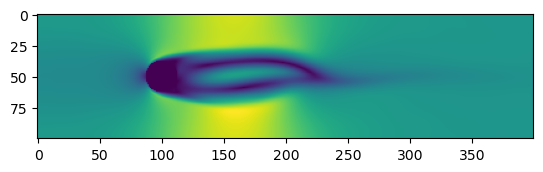

In [19]:
plot_step= 200

def distance(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)
def main():
    # defining the number of grid points and iterations
    nx= 400 
    ny= 100
    tau=.53
    tsteps= 3000
    #number of velocity vectors
    nvec=9
    
    #setting the projections for each
    vecx= np.array([0, 0, 1, 1, 1, 0, -1, -1, -1])
    vecy= np.array([0, 1, 1, 0, -1, -1, -1, 0, 1])
    weights= np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36])
    
    #initial conditions
    F= np.ones((ny, nx, nvec)) + .01*np.random.randn(ny, nx, nvec)
    F[:, :, 3]= 2.3
    
    #creating the cylinder
    cylinder= np.full((ny, nx), False)
    
    for y in range(0, ny):
        for x in range(0, nx):
            if (distance(nx//4, ny//2, x, y)<13):
                cylinder[y][x]= True;
                
    #the algorithm itself
    for s in range(tsteps):
        
        
        F[:, -1, [6,7,8]] = F[:, -2, [6,7,8]]
        F[:, 0, [2,3,4]] = F[:, 1, [2,3,4]]
        
        #updating the parameters for each iterations
        for i, cx, cy in zip(range(nvec), vecx, vecy):
            F[:, :, i]= np.roll(F[:, :, i], cx, axis= 1)
            F[:, :, i]= np.roll(F[:, :, i], cy, axis= 0)
            
        #setting the boundary conditions
        boundaryF= F[cylinder,:]
        boundaryF= boundaryF[:, [0, 5, 6, 7, 8, 1, 2, 3, 4]]
        
        #finding the parameters of the fluid
        rho= np.sum(F, 2)
        vx= np.sum(F*vecx, 2)/ rho
        vy= np.sum(F*vecy, 2)/ rho
        
        F[cylinder, :]= boundaryF
        vx[cylinder]=0
        vy[cylinder]=0
        
        #collisions
        Fequilibrium= np.zeros(F.shape)
        for i, cx, cy, w in zip(range(nvec), vecx, vecy, weights):
            Fequilibrium[:, :, i]= rho*w* (1 + 3*(cx*vx+cy*vy) + 9*(cx*vx+cy*vy)**2/2 - 3*(vx**2+vy**2)/2)
            
        F += -(1/tau)*(F-Fequilibrium)
            
        if(s%plot_step==0):
                pyplot.imshow(np.sqrt(vx**2+vy**2))
                
if __name__=="__main__":
    main()  
